# Задание 04 

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets
from collections import Counter
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook
import pandas as pd
import networkx as nx

%matplotlib inline

In [2]:
import random

In [3]:
np.random.seed(10)

In [4]:
def degreesToList(g):
    return np.array([d for n, d in g.degree()])

### Задача 1.  CCD
Функция распределения $CCD$ (complementary cumulative distribution) определяется как:
$$
F_{ccd}(x)=\sum_{x+1}^{\infty}p(x).
$$  
* напишите функцию, вычисляющую $F_{ccd}$ для заданного массива данных $X$ и числа отрезков $N_{bins}$, разбивающих промежуток $[X_{min},X_{max}]$:

In [5]:
def power_law(x_min,gamma):
    r = np.random.random()
    return round(x_min*np.float_power((r), 1/(-gamma+1))) # для генерации случайной величины 
                                                          # с экспоненциальным законом распределения

In [6]:
def ccd(x, n_bins):
    ticks = np.linspace(min(x), max(x), num=n_bins)
    hist = []
    for t in ticks:
        hist.append(sum([_>=t for _ in x]))
    return np.array(hist), np.array(ticks)

* постройте $F_{ccd}$ для случайной величины $x$ (двойная логарифмическая шкала);
* аппроксимируйте распределение прямой, сравните коэффициент с теоретическим.

In [7]:
x_min, gam = 10, 2.5
X = [power_law(x_min, gam)*_ for _ in np.ones(shape=(1000,))]

In [87]:
def plotCCDist(X, n_bins=200, title='Random exp-distributed array', axis=None, l=50):
    n_bins = 200
    dens, bin_edges = ccd(X, n_bins)
    bins = bin_edges/2

    nonzero_bins = bins[np.nonzero(bins)]
    nonzero_dens = dens[np.nonzero(dens)]
    linear_appr = np.polyfit(np.log(nonzero_bins)[:-l], np.log(nonzero_dens)[:-l], 1)
    print(linear_appr)
    
    plt.loglog(nonzero_bins, nonzero_dens, '--o')
    plt.loglog(nonzero_bins, nonzero_bins**linear_appr[0] * np.exp(linear_appr[1]), '--', color='r')
    
    plt.title(title)
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)
    plt.show()

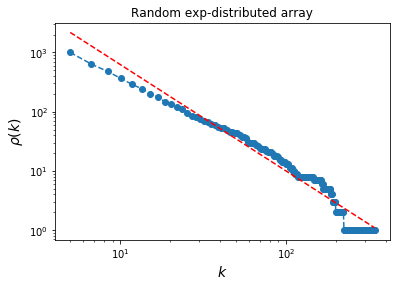

In [9]:
plotCCDist(X, 200)

* используя $F_{ccd}$ оцените коэффициент $\gamma$ распределения степеней связности заданных сетей;
* постройте $F_{ccd}$ и прямую аппроксимации для заданных сетей. Что можно сказать о малых степенях в сети?

In [10]:
G_list = [nx.read_edgelist('../data/bio-diseasome.txt'), 
          nx.read_edgelist('../data/bio-celegans.txt'), 
          nx.read_edgelist('../data/cit-HepTh.txt')]

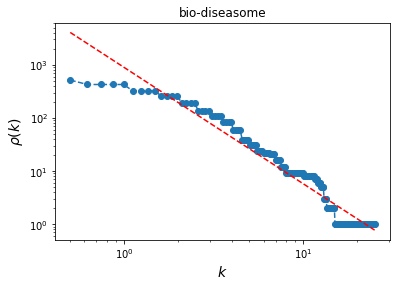

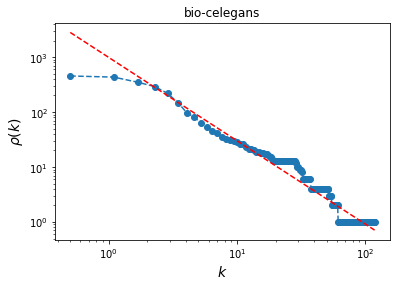

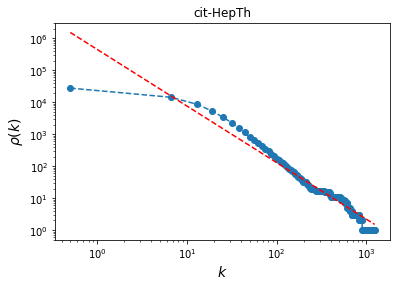

In [11]:
G_list_degrees = [degreesToList(g) for g in G_list]
for gd, t in zip(G_list_degrees, ['bio-diseasome', 'bio-celegans', 'cit-HepTh']):
    plotCCDist(gd, title=t) 

* постройте $F_{ccd}$ и прямую аппроксимации для случайной сети Барабаши-Альберта. Сравните коэффициент наклона прямой с теоретическим значением. 

In [12]:
averageNNodes = np.mean([g.number_of_nodes() for g in G_list])//2

In [13]:
ba_graph = nx.barabasi_albert_graph(n=averageNNodes, m=4, seed=10)

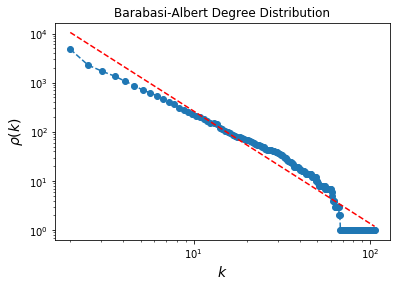

In [14]:
plotCCDist(degreesToList(ba_graph), title='Barabasi-Albert Degree Distribution') 

#### Задача 2. Предпочтительное присоединение
* напишите генератор случайного графа, построенного по принципу нелинейного предпочтительного присоединения:
$$
\Pi(k_i) \sim k_i^{\alpha}
$$
* постройте зависимость степени вершины (например, выберите одну из затравочных) от времени (размера сети) для значений $\alpha=0.5,1.0,2.5$. 

Рекомендуемые параметры: $m=4, t=[10^2,10^3,10^4,...]$.

In [15]:
def nonlinearPreferentialAttachment(n, alpha, t, m=4):
    g = nx.Graph()
    seed_nodes = np.arange(start=1, stop=n+1, dtype=int)
    loops = np.vstack((seed_nodes, seed_nodes)).transpose()
    g.add_nodes_from(seed_nodes)
    g.add_edges_from(loops)
    
    for it in range(1, t+1):
        degree_dist = Counter(degreesToList(g)-1).items()

        mu = sum([j**alpha * c/len(degree_dist) for j, c in degree_dist])
        prefAttScores = {d:d**alpha/(it*mu) for d, c in degree_dist}
        probs = np.array([prefAttScores[d] for d in degreesToList(g)-1])
        probs /= probs.sum() # нормировка
        chosen = np.random.choice(a=list(g.nodes()), size=m, p=probs, replace=False)
        g.add_node(n+it)
        g.add_edge(n+it, n+it)
        g.add_edges_from(list(zip(np.ones(m)*(n+it), chosen)))
    
    return g

In [16]:
times = np.array([1e0, 1e1, 1e2, 1e3, 1e4], dtype=int)
G_0_5 = [nonlinearPreferentialAttachment(4, 0.5, t=t) for t in tqdm(times, desc='alpha=0.5')]
G_1_0 = [nonlinearPreferentialAttachment(4, 1.0, t=t) for t in tqdm(times, desc='alpha=1.0')]
G_2_5 = [nonlinearPreferentialAttachment(4, 2.5, t=t) for t in tqdm(times, desc='alpha=2.5')]

In [50]:
first_node_degrees = np.array([[g.degree()[1] for g in graphs] for graphs in [G_0_5, G_1_0, G_2_5]])

In [58]:
nonlinData = pd.DataFrame(np.hstack((first_node_degrees.T, times.reshape(-1, 1))), columns=['0.5', '1.0', '2.5', 'times'])

In [66]:
nonlinData.index = nonlinData.times
del nonlinData['times']

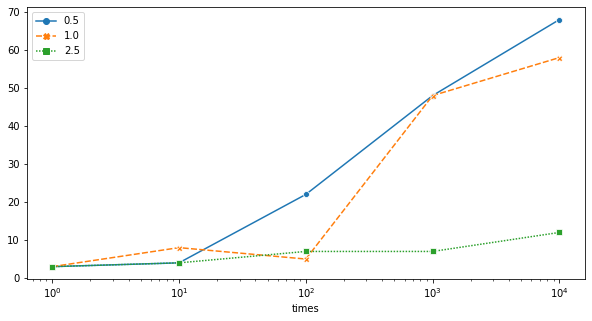

In [77]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(data=nonlinData, markers=True)
plt.xscale('log')
plt.show()

### Задача 3. Модель Бьянкони-Барабаши. 
* напишите генератор случайного графа, где вероятность связи новой вершины $l$ определяется:

$$
P(l,i) =\frac{\eta_i k_i}{\sum_j \eta_j k_j},
$$
* $\eta_i$ - случайная величина из равномерного распределения на $[0,1]$.

1)  постройте зависимости степеней вершин (например, начальных) от времени. Какому закону подчиняется зависчимость? Каким образом зависит от параметра $\eta$?

2)  постройте распределение по степеням связности (например, используя $F_{ccd}$), аппроксимируйте степенным законом. Каков показатель степени? 

3) * (дополнительно) Исследуйте топологию сетей при разных распределениях $\rho(\eta)$: нормальное, экспоненциальное, степенное.

In [18]:
def bianconiPreferentialAttachment(n, alpha, t, m=4):
    g = nx.Graph()
    seed_nodes = np.arange(start=1, stop=n+1, dtype=int)
    loops = np.vstack((seed_nodes, seed_nodes)).transpose()
    g.add_nodes_from(seed_nodes)
    g.add_edges_from(loops)
    
    for it in range(1, t+1):
        
        etas = np.random.uniform(size=g.number_of_nodes())
        probs = np.array([eta*k for k, eta in zip(degreesToList(g)-1, etas)])/\
                sum([eta*k for k, eta in zip(degreesToList(g)-1, etas)])
        probs /= probs.sum() # нормировка
        
        chosen = np.random.choice(a=list(g.nodes()), size=m, p=probs, replace=False)
        g.add_node(n+it)
        g.add_edge(n+it, n+it)
        g.add_edges_from(list(zip(np.ones(m)*(n+it), chosen)))
    
    return g

In [19]:
times = np.array([1e0, 1e1, 1e2, 1e3, 1e4], dtype=int)
G_bianconi = [bianconiPreferentialAttachment(4, 0.5, t=t) for t in tqdm(times, desc='alpha=0.5')]

In [78]:
np.save('./biancony.npy', G_bianconi)
np.save('./nonlinear-0.5.npy', G_0_5)
np.save('./nonlinear-2.5.npy', G_2_5)
np.save('./nonlinear-1.0.npy', G_1_0)

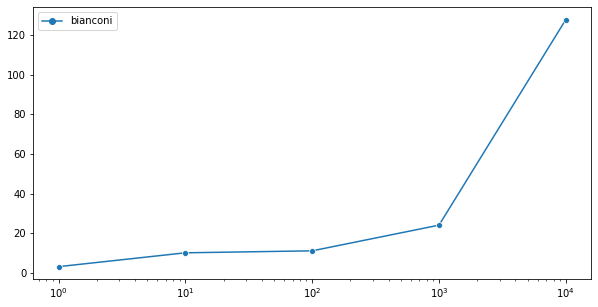

In [79]:
fig = plt.figure(figsize=(10,5))
first_node_degrees_bianconi = np.array([g.degree()[1] for g in G_bianconi])
bianconiData = pd.DataFrame(first_node_degrees_bianconi, index=times, columns=['bianconi'])
sns.lineplot(data=bianconiData, markers=True)
plt.xscale('log')
plt.show()

[-2.70887472  5.28930873]


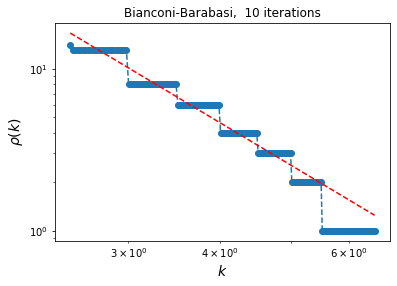

[-2.29877144  7.11668735]


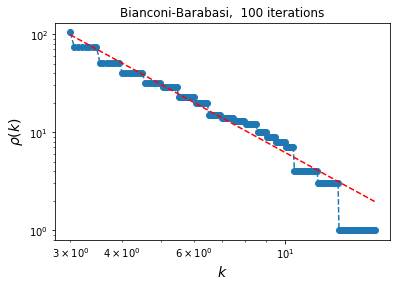

[-2.33739069  9.46245855]


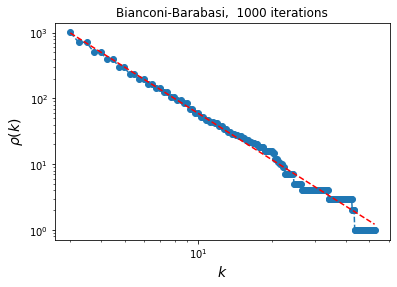

[-2.52693837 12.39041887]


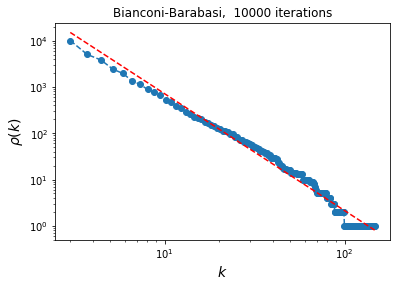

In [89]:
bianconi_degree_distributions = np.array([degreesToList(g) for g in G_bianconi])
for b, t in zip(bianconi_degree_distributions[1:], times[1:]):
    plotCCDist(b, title='Bianconi-Barabasi,  {} iterations'.format(t))

Показатель степени $\vargamma$ для модели Бьянкони-Барабаши приблизительно равен $2$